In [15]:
import joblib
import dalex as dx
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lime.lime_tabular
import lime.lime_image
import warnings

sys.path.append('../')

import shap

plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

warnings.filterwarnings('ignore')
from src import LogisticRegression, metrics
from sklearn.model_selection import train_test_split

In [16]:
# Load model
model = joblib.load('../src/output_models/LR_model.pkl')

In [17]:
# Load data
df = pd.read_csv('../dataset/breast-cancer-wisconsin-processed.csv')
label = pd.read_csv('../dataset/breast-cancer-wisconsin-processed-label.csv')
data = pd.concat([df, label], axis=1)

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Using 432 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/108 [00:00<?, ?it/s]

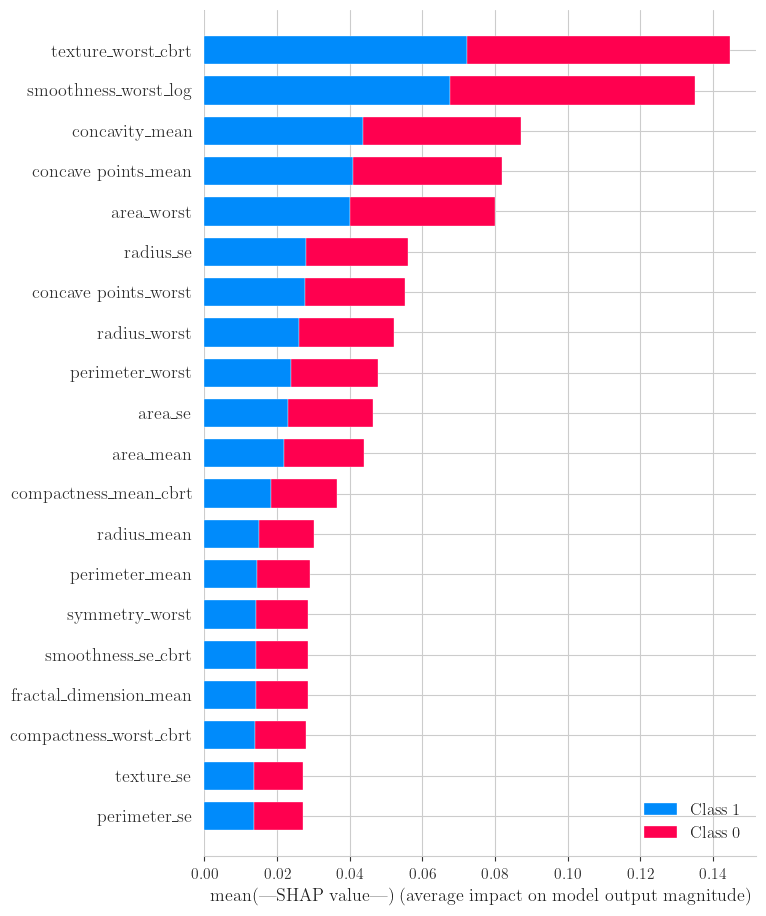

In [18]:
shape_lr_explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = shape_lr_explainer.shap_values(X_test, nsamples=100)
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.savefig('../src/output_plots/LR_shap_summary_plot.png')
plt.show()

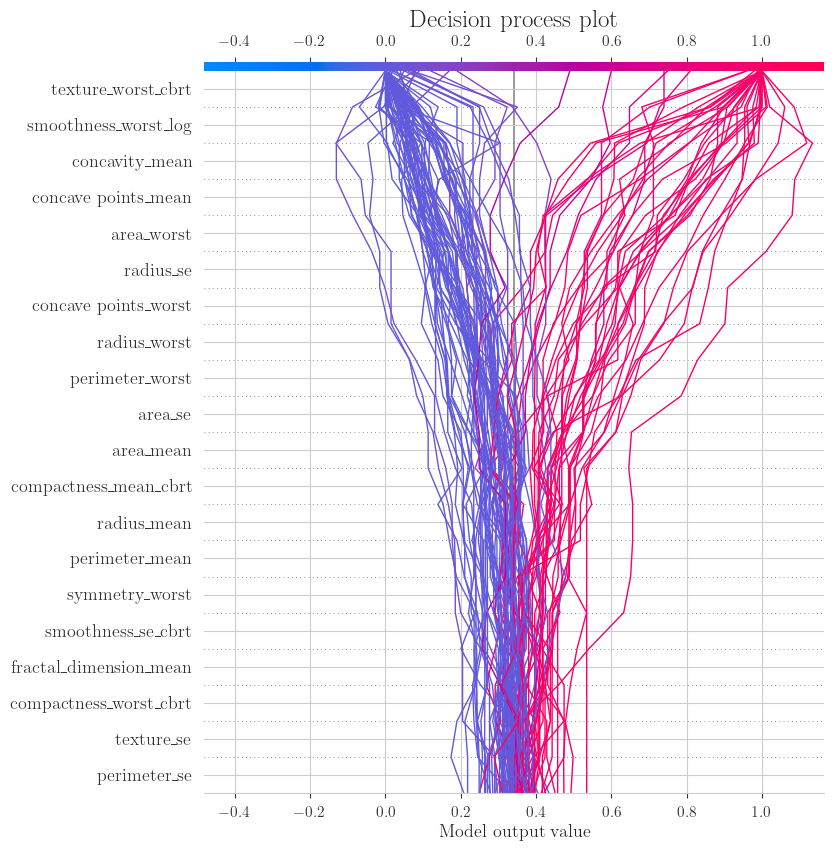

In [19]:
# Plot the shap decision plot
shap.decision_plot(shape_lr_explainer.expected_value[1], shap_values[1], X_test, show=False)
plt.title('Decision process plot')
plt.savefig('../src/output_plots/LR_shap_decision_plot.png')
plt.show()

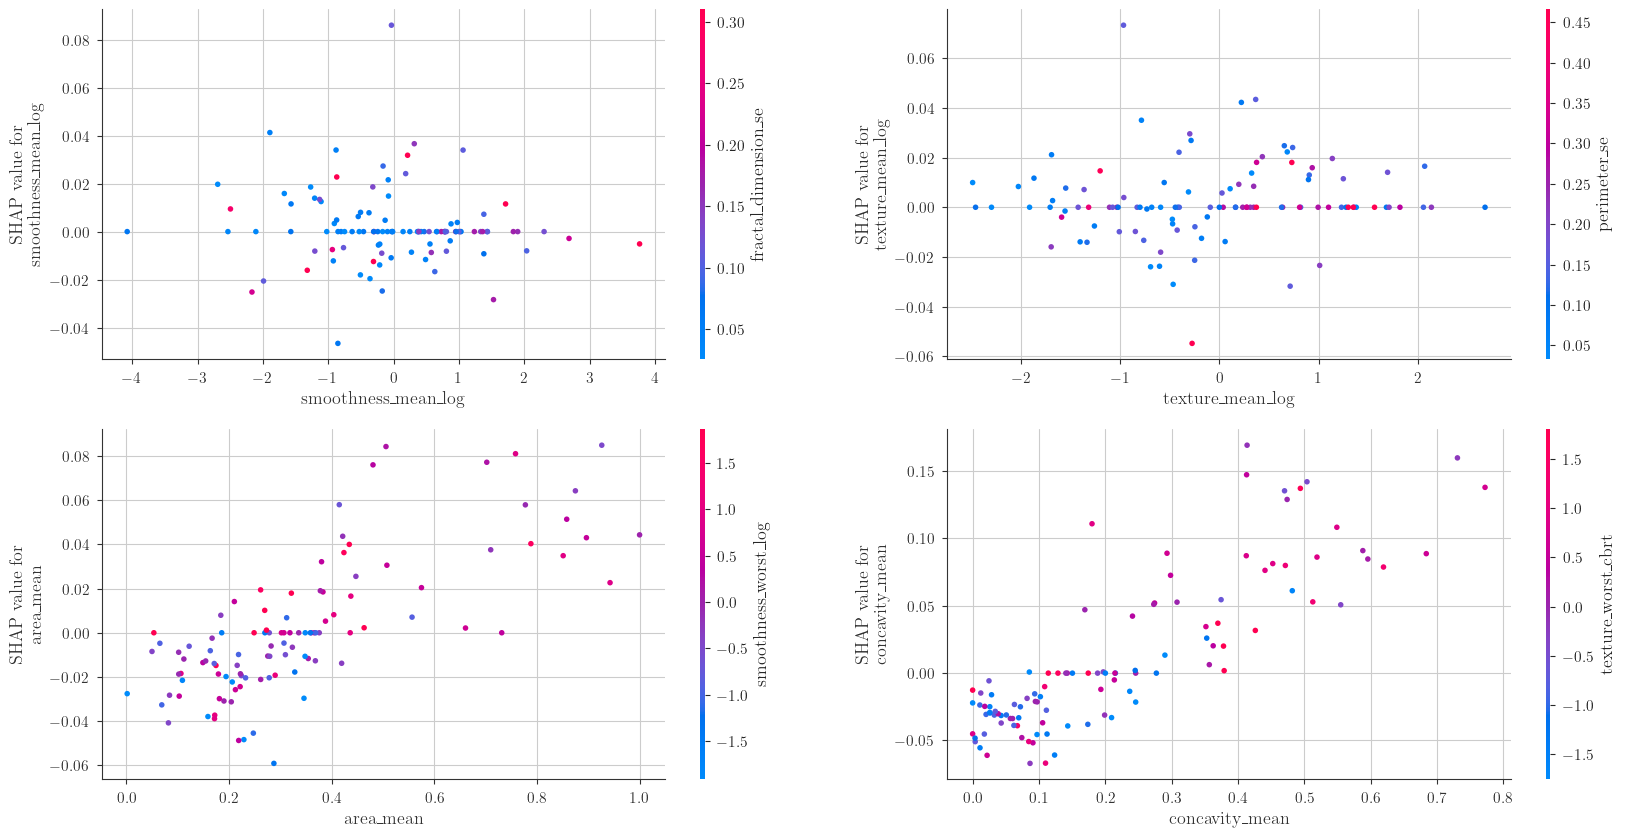

In [20]:
# Plot dependence plot for 4 most important features
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
shap.dependence_plot('smoothness_mean_log', shap_values[1], X_test, show=False, ax=ax[0, 0])
shap.dependence_plot('texture_mean_log', shap_values[1], X_test, show=False, ax=ax[0, 1])
shap.dependence_plot('area_mean', shap_values[1], X_test, show=False, ax=ax[1, 0])
shap.dependence_plot('concavity_mean', shap_values[1], X_test, show=False, ax=ax[1, 1])
plt.savefig('../src/output_plots/LR_shap_dependence_plot.png')
plt.show()

In [21]:
# Create explainer object dalex
dx_lr_explainer = dx.Explainer(model, X_train, y_train, label='Logistic Regression')

Preparation of a new explainer is initiated

  -> data              : 432 rows 30 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 432 values
  -> model_class       : src.LogisticRegression.LogisticRegression (default)
  -> label             : Logistic Regression
  -> predict function  : <function yhat_proba_default at 0x7fe61aff40e0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.343, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.59, mean = -0.000185, max = 1.0
  -> model_info        : package src

A new explainer has been created!


In [22]:
dx_lr_explainer.model_performance()

,recall,precision,f1,accuracy,auc
Logistic Regression,0.972973,0.993103,0.982935,0.988426,0.994135


In [23]:
dx_lr_explainer.model_parts()

,variable,dropout_loss,label
0,texture_se,0.004074,Logistic Regression
1,perimeter_mean,0.004192,Logistic Regression
2,perimeter_worst,0.004306,Logistic Regression
3,symmetry_worst,0.004413,Logistic Regression
4,concave points_worst,0.004916,Logistic Regression
5,fractal_dimension_worst,0.004944,Logistic Regression
6,radius_mean,0.005005,Logistic Regression
7,concave points_mean,0.005094,Logistic Regression
8,area_mean,0.005114,Logistic Regression
9,fractal_dimension_mean,0.005152,Logistic Regression


In [24]:
dx_lr_explainer.model_parts().plot()

In [25]:
# Get misclassified samples from test set and plot them as prediction parts
misclassified = X_test[y_test != model.predict(X_test)]
misclassified = misclassified.reset_index(drop=True)

In [26]:
dx_lr_explainer.predict_parts(misclassified.iloc[0]).plot()

In [27]:
dx_lr_explainer.predict_parts(misclassified.iloc[1]).plot()